# Deep Q Network Tutorial

## 1. Environment Preparation
### 1.1 Mount drive and set project path.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
project_root = '/content/drive/My Drive/DQN_tutorial/'
sys.path.append(project_root)

Mounted at /content/drive


### 1.2 Download Atari ROM.

In [3]:
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unzip e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/
! pip install "gym[atari, accept-rom-license]"
! pip install numpy==1.24.4


--2025-07-08 15:22:15--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 212.83.163.6
Connecting to www.atarimania.com (www.atarimania.com)|212.83.163.6|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.atarimania.com/roms/Roms.rar [following]
--2025-07-08 15:22:15--  https://www.atarimania.com/roms/Roms.rar
Connecting to www.atarimania.com (www.atarimania.com)|212.83.163.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19612325 (19M) [application/octet-stream]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.70M  7.87MB/s    in 2.4s    

2025-07-08 15:22:18 (7.87 MB/s) - ‘Roms.rar’ saved [19612325/19612325]

unzip:  cannot find or open e, e.zip or e.ZIP.
/usr/bin/python3: Error while finding module specification for 'atari_py.import_roms' (ModuleNotFoundError: No module named 'atari_py')
INFO: pip is looking at multiple versions of gym[ac

## 2. Pong Game and Wrapper
### 2.1 Test the pong environment.

environment: PongNoFrameskip-v4
action space: 6
action: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
observation space: (210, 160, 3)


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


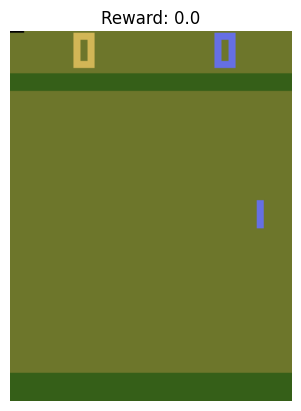

In [1]:
import gym
import matplotlib.pyplot as plt

env_name = "PongNoFrameskip-v4"
env = gym.make(env_name, render_mode="rgb_array")

print("environment:", env_name)
print("action space:", env.action_space.n)
print("action:", env.unwrapped.get_action_meanings())
print("observation space:", env.observation_space.shape)

state = env.reset()
action = env.action_space.sample()
state_next, reward, terminated, truncated, info = env.step(action)

image = env.render()
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.title(f"Reward: {reward}")
plt.show()

### 2.2 Environment wrapper.

In [2]:
import numpy as np
from PIL import Image
import gym

class PongEnvWrapper(gym.Wrapper):
    def __init__(self, env, k, img_size=(84,84)):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.img_size = img_size
        obs_shape = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(k, img_size[0], img_size[1]), dtype=np.float32)

    def _preprocess(self, state, th=0.4): #Image processing.
        state = np.array(Image.fromarray(state).resize(self.img_size,Image.BILINEAR))
        state = state.astype(np.float32).mean(2)/255.
        state[state > th] = 1
        state[state <= th] = 0
        return state


    def reset(self):
        state,_ = self.env.reset()
        state = self._preprocess(state)
        state = state[np.newaxis,...].repeat(self.k,axis = 0)
        return state,_

    def step(self, action):
        state_next =[]
        info = []
        reward = 0
        done = False
        for i in range(self.k):
          if not done:
            state_next_f,reward_f,terminated_f,done_f,info_f = self.env.step(action)
            state_next_f = self._preprocess(state_next_f)
            reward += reward_f
            done = done_f
            info.append(info_f)
          state_next.append(state_next_f[np.newaxis,...])
        state_next = np.concatenate(state_next,0)
        return state_next, reward, done, info

observation space: (4, 84, 84)
(4, 84, 84)


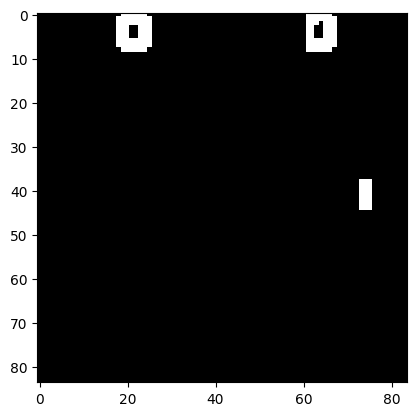

In [3]:
# Test Code
env_pong = PongEnvWrapper(env, k=4, img_size=(84,84))
print("observation space:", env_pong.observation_space.shape)

state = env_pong.reset()
action = env_pong.action_space.sample()
state_next, reward, done, info = env_pong.step(action)
print(state_next.shape)
plt.imshow(state_next[0], cmap="gray")

## 3. Reinforcement Learning
### 3.1 Convolutional Neural Network

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QNet(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(QNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
        )


        dummy_input = torch.zeros(1, *input_shape)
        conv_out = self.conv(dummy_input)
        conv_out_size = conv_out.view(1, -1).size(1)


        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # 展平成 batch_size x conv_out_size
        x = self.fc(x)
        return x



### 3.2 DQN Algorithm

In [30]:
class DeepQNetwork():
    def __init__(
        self,
        n_actions,
        input_shape,
        qnet,
        device,
        learning_rate = 2e-4,
        reward_decay = 0.99,
        replace_target_iter = 1000,
        memory_size = 10000,
        batch_size = 32,
    ):
        # initialize parameters
        self.n_actions = n_actions
        self.input_shape = input_shape
        self.lr = learning_rate
        self.gamma = reward_decay
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.device = device
        self.learn_step_counter = 0
        self.init_memory()

        # Network
        self.qnet_eval = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target = qnet(self.input_shape, self.n_actions).to(self.device)
        self.qnet_target.eval()
        self.optimizer = optim.RMSprop(self.qnet_eval.parameters(), lr=self.lr)

    def choose_action(self, state, epsilon=0):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        actions_value = self.qnet_eval.forward(state)
        if np.random.uniform() > epsilon:   # greedy
            action = torch.max(actions_value, 1)[1].data.cpu().numpy()[0]
        else:   # random
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.qnet_target.load_state_dict(self.qnet_eval.state_dict())
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        b_s = torch.FloatTensor(self.memory["s"][sample_index]).to(self.device)
        b_a = torch.LongTensor(self.memory["a"][sample_index]).to(self.device)
        b_r = torch.FloatTensor(self.memory["r"][sample_index]).to(self.device)
        b_s_ = torch.FloatTensor(self.memory["s_"][sample_index]).to(self.device)
        b_d = torch.FloatTensor(self.memory["done"][sample_index]).to(self.device)
        #---
        q_curr_eval = self.qnet_eval(b_s).gather(1, b_a)
        q_next_target = self.qnet_target(b_s_).detach()
        next_state_value = q_next_target.max(1)[0].view(self.batch_size, 1) # -> DQN
        # q_next_eval = self.qnet_eval(b_s_).detach()                   # -> DDQN
        # next_state_value = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1)) # -> DDQN
        q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_value
        #-----
        self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.learn_step_counter += 1
        return self.loss.detach().cpu().numpy()


    def init_memory(self):
        self.memory = {
            "s": np.zeros((self.memory_size, *self.input_shape)),
            "a": np.zeros((self.memory_size, 1)),
            "r": np.zeros((self.memory_size, 1)),
            "s_": np.zeros((self.memory_size, *self.input_shape)),
            "done": np.zeros((self.memory_size, 1)),
        }

    def store_transition(self, s, a, r, s_, d):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        if self.memory_counter <= self.memory_size:
            index = self.memory_counter % self.memory_size
        else:
            index = np.random.randint(self.memory_size)
        self.memory["s"][index] = s
        self.memory["a"][index] = np.array(a).reshape(-1,1)
        self.memory["r"][index] = np.array(r).reshape(-1,1)
        self.memory["s_"][index] = s_
        self.memory["done"][index] = np.array(d).reshape(-1,1)
        self.memory_counter += 1

    def save_load_model(self, op, path="save", fname="qnet.pt"):
        import os
        if not os.path.exists(path):
            os.makedirs(path)
        file_path = os.path.join(path, fname)
        if op == "save":
            torch.save(self.qnet_eval.state_dict(), file_path)
        elif op == "load":
            self.qnet_eval.load_state_dict(torch.load(file_path, map_location=self.device))
            self.qnet_target.load_state_dict(torch.load(file_path, map_location=self.device))

In [31]:
stack_frames = 4
img_size = (84,84)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DeepQNetwork(
        n_actions = env.action_space.n,
        input_shape = [stack_frames, *img_size],
        qnet = QNet,
        device = device,
        learning_rate = 2e-4,
        reward_decay = 0.99,
        replace_target_iter = 1000,
        memory_size = 10000,
        batch_size = 32,)

print(agent.qnet_eval)

QNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


## 4. Training and testing process.
### 4.1 Play the game.

In [32]:
def play(env, agent, stack_frames, img_size):
    state,_ = env.reset()
    # img = (state[0].squeeze() * 255).astype(np.uint8)
    # img_buffer = [Image.fromarray(img)]
    img = (state[0] * 255).astype(np.uint8)  # state[0] 是灰階圖
    img_buffer = [Image.fromarray(img)]

    step = 0
    total_reward = 0

    while True:
        action = agent.choose_action(state, 0)
        state_next, reward, done, info = env.step(action)

        # if step % 2 == 0:
            # img = (state_next[0].squeeze() * 255).astype(np.uint8)
            # img_buffer.append(Image.fromarray(img))
        if step % 2 == 0:
            img = (state_next[0] * 255).astype(np.uint8)
            img_buffer.append(Image.fromarray(img))

        state = state_next.copy()
        step += 1
        total_reward += reward
        print('\rStep: {:3d} | Reward: {:.3f} / {:.3f}'\
            .format(step, reward, total_reward), end="")

        if done or step > 2000:
            print()
            break

    return img_buffer


In [33]:
import os
project_root = os.getcwd()
def save_gif(img_buffer, fname, gif_path=os.path.join(project_root, "gif")):
    if not os.path.exists(gif_path):
        os.makedirs(gif_path)
    img_buffer[0].save(os.path.join(gif_path, fname), save_all=True, append_images=img_buffer[1:], duration=1, loop=0)

In [34]:
# Test Code
print("state[0] shape before squeeze:", state[0].shape)
img_buffer = play(env_pong, agent, stack_frames, img_size)
save_gif(img_buffer, fname="test.gif")

state[0] shape before squeeze: (4, 84, 84)
Step: 2001 | Reward: 0.000 / -21.000


### 4.2 Epsilon greedy computation.

In [35]:
def epsilon_compute(frame_id, epsilon_max=1, epsilon_min=0.05, epsilon_decay=100000):
    return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-frame_id / epsilon_decay)

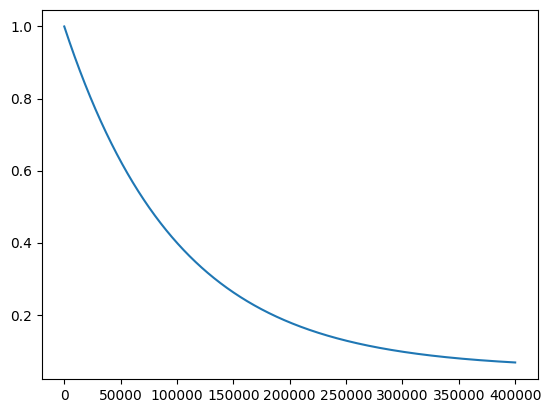

In [36]:
# Test Code
frame_ids = np.array(range(400000))
epsilons = epsilon_compute(frame_ids)
plt.plot(epsilons)

### 4.3 Training steps.

In [41]:
def train(env, agent, stack_frames, img_size, save_path="save", max_steps=1000000):
    total_step = 0
    episode = 0
    while True:
        # Reset environment.
        state,_ = env.reset()

        # Initialize information.
        step = 0
        total_reward = 0
        loss = 0

        # One episode.
        while True:
            epsilon = epsilon_compute(total_step)
            action = agent.choose_action(state, epsilon)
            state_next, reward, done, info = env.step(action)
            agent.store_transition(state, action, reward, state_next, done)
            if total_step > 4*agent.batch_size:
                loss = agent.learn()
            state = state_next.copy()
            step += 1
            total_step += 1
            total_reward += reward

            state = state_next.copy()
            step += 1
            total_step += 1
            total_reward += reward

            if total_step % 100 == 0 or done:
                print('\rEpisode: {:3d} | Step: {:3d} / {:3d} | Reward: {:.3f} / {:.3f} | Loss: {:.3f} | Epsilon: {:.3f}'\
                    .format(episode, step, total_step, reward, total_reward, loss, epsilon), end="")

            if total_step % 10000 == 0:
                print("\nSave Model ...")
                agent.save_load_model(op="save", path=save_path, fname="qnet.pt")
                print("Generate GIF ...")
                img_buffer = play(env, agent, stack_frames, img_size)
                save_gif(img_buffer, "train_" + str(total_step).zfill(6) + ".gif")
                print("Done !!")

            if done or step>2000:
                episode += 1
                print()
                break

        if total_step > max_steps:
            break

In [ ]:
train(env_pong, agent, stack_frames, img_size, save_path=os.path.join(project_root, "save"), max_steps=400000)

Episode:   0 | Step: 1000 / 1000 | Reward: 0.000 / -20.000 | Loss: 0.001 | Epsilon: 0.991

### 4.4 Evaluate the trained model.

In [ ]:
agent.save_load_model(op="load", path=os.path.join(project_root, "save"), fname="qnet.pt")
img_buffer = play(env_pong, agent, stack_frames, img_size)
save_gif(img_buffer, "eval.gif")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')